In [6]:
import numpy as np
import matplotlib.pyplot as plt
#从scipy.stats模块导入multivariate_normal函数。该函数允许生成多变量正态分布的随机样本，并计算概率密度函数（PDF）
from scipy.stats import multivariate_normal

In [7]:
#这个 debug 函数可以作为一个辅助函数，用于在调试模式下输出调试信息。
#通过在代码中调用 debug 函数，可以根据需要控制是否打印调试信息。
#这对于在开发和调试阶段查找问题和跟踪代码执行流程非常有用。
#需要注意的是，要确保在调试模式下将全局变量 DEBUG 设置为 True，以便使 debug 函数生效。

DEBUG = True

def debug(*args, **kwargs):
    global DEBUG
    if DEBUG:
        print(*args, **kwargs)


In [8]:
# 该函数接受三个参数：

# Y：数据点，表示要计算概率密度函数值的数据点。
# mu_k：高斯分布的均值参数，表示该高斯分布的中心位置。
# cov_k：高斯分布的协方差参数，表示该高斯分布的变化程度。
# 在函数内部，通过调用 multivariate_normal 函数创建了一个 norm 对象，该对象表示了一个具有给定均值和协方差的多变量正态分布。

# 然后，使用 norm.pdf(Y) 计算了给定数据点 Y 在该正态分布下的概率密度函数值，并将其作为函数的返回值。

# 这个函数 phi 可以用于计算给定数据点在指定高斯分布下的概率密度函数值。
# 概率密度函数值表示了数据点在该高斯分布中的相对可能性或密度。它在高斯混合模型 (GMM) 等概率模型中经常用于计算样本的分配概率或后验概率。

def phi(Y, mu_k, cov_k):
    norm = multivariate_normal(mean=mu_k, cov=cov_k)
    return norm.pdf(Y)

In [9]:
# E 步：计算每个模型对样本的响应度

# 这个函数接受四个参数：

# Y：数据集，表示要计算响应度矩阵的数据集。
# mu：高斯混合模型的均值参数，表示每个高斯模型的中心位置。
# cov：高斯混合模型的协方差参数，表示每个高斯模型的变化程度。
# alpha：高斯混合模型的权重参数，表示每个高斯模型在整个混合模型中的权重。

# 在高斯混合模型（GMM）中，响应度是指一个数据点属于每个组件或聚类的概率。换句话说，响应度告诉我们一个数据点在每个组件中的“归属程度”。

def getExpectation(Y, mu, cov, alpha):
    N = Y.shape[0]  # 样本数
    K = alpha.shape[0]  # 模型数

    assert N > 1, "There must be more than one sample!"  # 断言：样本数必须大于1
    assert K > 1, "There must be more than one gaussian model!"  # 断言：模型数必须大于1

    # 创建一个空的响应度矩阵 gamma，其大小为 (N, K)，用于存储每个样本在每个模型下的响应度。
    gamma = np.mat(np.zeros((N, K))) 
    
    # 初始化一个空的概率矩阵 prob，大小为 (N, K)，用于存储每个样本在每个模型下的概率密度函数值。
    # 通过循环遍历每个模型，调用之前定义的 phi 函数计算每个样本在每个模型下的概率密度函数值。
    prob = np.zeros((N, K))  
    
    # 最终，prob 是一个大小为 (N, K) 的二维数组，其中 N 是数据点的数量，K 是高斯分布组件的数量。
    # prob 中的每个元素 prob[i, k] 表示数据点 Y[i] 在高斯分布组件 k 下的概率密度函数值。
    for k in range(K):
        prob[:, k] = phi(Y, mu[k], cov[k])  # 计算每个样本在每个模型下的概率
    
    # 将概率矩阵 prob 转换为一个 NumPy 矩阵对象，以便后续计算。
    prob = np.mat(prob)

    # 计算每个模型对每个样本的响应度
    # 计算每个模型对每个样本的响应度，即将每个样本在每个模型下的概率乘以相应的权重 alpha。
    for k in range(K):
        gamma[:, k] = alpha[k] * prob[:, k]  # 计算响应度
    
    # 对每个样本的响应度进行归一化处理，确保每个样本的响应度之和为1。             
    for i in range(N):
        gamma[i, :] /= np.sum(gamma[i, :])  # 归一化每个样本的响应度

    return gamma


In [10]:
# Y：数据集，表示要用于估计参数的数据集。
# gamma：响应度矩阵，表示数据集中每个样本属于每个高斯模型的响应度。



def maximize(Y, gamma):
    # 样本数和特征数
    N, D = Y.shape
    # 模型数
    K = gamma.shape[1]

    #初始化参数值
    mu = np.zeros((K, D)) #  K 表示数组的行数（模型数），D 表示数组的列数（特征数）。
    cov = []
    alpha = np.zeros(K)

    # 更新每个模型的参数
    for k in range(K):
        # 第 k 个模型对所有样本的响应度之和
        # 通过循环遍历每个模型 k，计算每个模型对所有样本的响应度之和 Nk。
        Nk = np.sum(gamma[:, k])
        
        # 更新高斯混合模型的均值参数 mu。通过循环遍历每个模型 k 的特征维度 d，计算每个模型在每个特征上的均值。
        for d in range(D):
            mu[k, d] = np.sum(np.multiply(gamma[:, k], Y[:, d])) / Nk
        
        # 更新 cov
        # 通过循环遍历每个样本 i，计算每个模型 k 在样本 i 上的协方差。
        cov_k = np.mat(np.zeros((D, D)))
        for i in range(N):
            cov_k += gamma[i, k] * (Y[i] - mu[k]).T * (Y[i] - mu[k]) / Nk
        cov.append(cov_k)
        # 更新 alpha
        alpha[k] = Nk / N
    cov = np.array(cov)
    return mu, cov, alpha

首先，我们创建一个大小为 (D, D) 的零矩阵 cov_k，其中 D 表示特征维度的数量。这个矩阵用于累加每个样本在模型 k 下的协方差贡献。

接下来，通过循环遍历数据集中的每个样本 i，进行以下操作：

计算样本 i 在模型 k 下的特征差异向量 (Y[i] - mu[k])。其中，Y[i] 是一个 (D, 1) 的列向量，表示数据集中的第 i 个样本，mu[k] 也是一个 (D, 1) 的列向量，表示模型 k 的均值参数。

将特征差异向量进行转置乘积 (Y[i] - mu[k]).T * (Y[i] - mu[k])，得到一个 (D, D) 的矩阵，表示样本 i 在模型 k 下的协方差贡献。

将协方差贡献乘以响应度 gamma[i, k]，并除以模型 k 对所有样本的响应度之和 Nk，以进行归一化。

将归一化的协方差贡献累加到 cov_k 中，以得到模型 k 在数据集上的协方差矩阵贡献。

循环结束后，将 cov_k 添加到列表 cov 中，表示模型 k 的协方差矩阵。

总结：

cov_k 是一个 (D, D) 的协方差矩阵，用于累加每个样本在模型 k 下的协方差贡献。

Y[i] - mu[k] 是一个 (D, 1) 的特征差异向量，表示样本 i 在模型 k 下的特征差异。

(Y[i] - mu[k]).T * (Y[i] - mu[k]) 是一个 (D, D) 的矩阵，表示样本 i 在模型 k 下的协方差贡献。

gamma[i, k] 是样本 i 在模型 k 下的响应度。

Nk 是模型 k 对所有样本的响应度之和。

In [11]:
# 数据预处理
# 将所有数据都缩放到 0 和 1 之间
def scale_data(Y):
    # 对每一维特征分别进行缩放
    for i in range(Y.shape[1]):
        max_ = Y[:, i].max()
        min_ = Y[:, i].min()
        Y[:, i] = (Y[:, i] - min_) / (max_ - min_)
    debug("Data scaled.")
    return Y

In [12]:
def init_params(shape, K):
    N, D = shape
    mu = np.random.rand(K, D)
    cov = np.array([np.eye(D)] * K)
    alpha = np.array([1.0 / K] * K)
    debug("Parameters initialized.")
    debug("mu:", mu, "cov:", cov, "alpha:", alpha, sep="\n")
    return mu, cov, alpha

在函数内部，我们执行以下操作：

从 shape 中获取数据集的样本数量 N 和特征维度 D。

使用 np.random.rand(K, D) 生成一个大小为 (K, D) 的随机矩阵 mu，表示每个聚类的均值参数。这里使用了 np.random.rand 函数生成范围在 0 到 1 之间的随机值。

使用 np.eye(D) 生成一个大小为 (D, D) 的单位矩阵，表示每个聚类的初始协方差参数。然后，使用 [np.eye(D)] * K 创建一个长度为 K 的列表，并将单位矩阵复制 K 次，得到一个包含 K 个单位矩阵的数组 cov。

使用 1.0 / K 生成初始权重，表示每个聚类的初始权重相等。然后，使用 [1.0 / K] * K 创建一个长度为 K 的列表，并将初始权重复制 K 次，得到一个包含 K 个初始权重的数组 alpha。

输出调试信息 "Parameters initialized."，并打印初始化的均值参数 mu、协方差参数 cov 和权重 alpha。

返回初始化的均值参数 mu、协方差参数 cov 和权重 alpha。

通过这段代码，我们可以得到一个初始的高斯混合模型参数，用于后续的 EM 算法迭代。其中，均值参数 mu 是一个大小为 (K, D) 的矩阵，协方差参数 cov 是一个包含 K 个大小为 (D, D) 的矩阵的数组，权重 alpha 是一个大小为 K 的数组。这些参数将在 EM 算法中被迭代更新，以拟合数据集的聚类分布。

In [13]:
def GMM_EM(Y, K, times):
    Y = scale_data(Y)
    mu, cov, alpha = init_params(Y.shape, K)
    for i in range(times):
        gamma = getExpectation(Y, mu, cov, alpha)
        mu, cov, alpha = maximize(Y, gamma)
    debug("{sep} Result {sep}".format(sep="-" * 20))
    debug("mu:", mu, "cov:", cov, "alpha:", alpha, sep="\n")
    return mu, cov, alpha

在函数内部，我们执行以下操作：

调用 scale_data 函数对数据集 Y 进行特征缩放，将特征的取值范围映射到 0 到 1 之间。

调用 init_params 函数初始化高斯混合模型的参数，包括均值参数 mu、协方差参数 cov 和权重 alpha。

进行指定次数的迭代（times 次）：

调用 getExpectation 函数计算每个样本在每个模型下的响应度，得到响应度矩阵 gamma。

调用 maximize 函数根据响应度矩阵 gamma 更新模型的参数，包括均值参数 mu、协方差参数 cov 和权重 alpha。

输出调试信息，打印最终的参数 mu、cov 和 alpha。

返回最终的参数 mu、cov 和 alpha。

通过这段代码，我们可以调用 GMM_EM 函数来执行高斯混合模型的 EM 算法，用于拟合给定数据集的聚类分布。最终返回的参数 mu、cov 和 alpha 表示拟合得到的聚类模型的均值、协方差和权重信息。

Data scaled.
Parameters initialized.
mu:
[[0.95133516 0.0969868 ]
 [0.62676278 0.35536612]
 [0.2335137  0.15658278]
 [0.4578518  0.24468324]]
cov:
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
alpha:
[0.25 0.25 0.25 0.25]
-------------------- Result --------------------
mu:
[[0.78121109 0.70779633]
 [0.59919691 0.54476852]
 [0.06508703 0.18078112]
 [0.14493615 0.23556668]]
cov:
[[[ 0.01113991  0.00180587]
  [ 0.00180587  0.01005579]]

 [[ 0.04065657  0.03927817]
  [ 0.03927817  0.04557858]]

 [[ 0.00033152 -0.00066445]
  [-0.00066445  0.00932292]]

 [[ 0.00358448  0.0019349 ]
  [ 0.0019349   0.01263728]]]
alpha:
[0.57159937 0.08966191 0.12515854 0.21358018]
category:[0, 2, 1, 3, 0, 1, 0, 0, 3, 0, 2, 0, 0, 2, 0, 3, 2, 0, 3, 0, 2, 2, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 3, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 3, 0, 3, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 3, 0, 2, 0, 2, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 2, 0, 

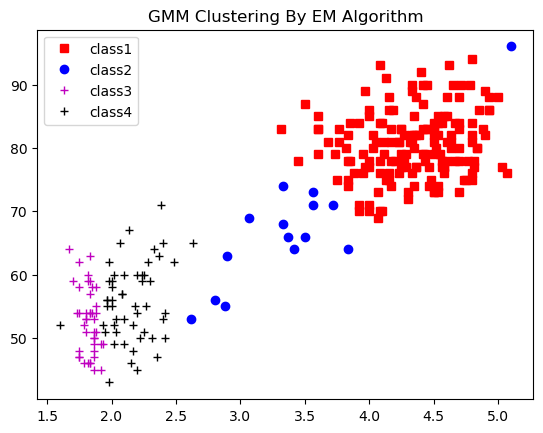

In [19]:
import matplotlib.pyplot as plt

# 设置调试模式
DEBUG = True

# 载入数据
# 我们加载数据集 gmm.data 并将其转换为矩阵 matY
Y = np.loadtxt("gmm.data")
matY = np.matrix(Y, copy=True)

# 模型个数，即聚类的类别个数
K = 4

# 计算 GMM 模型参数
mu, cov, alpha = GMM_EM(matY, K, 1000)

# N = Y.shape[0] 获取样本数据集中样本的数量。
# 调用 getExpectation 函数，传入样本数据 matY、GMM 模型的均值参数 mu、协方差参数 cov 和权重参数 alpha，
# 计算当前模型参数下，各模型对样本的响应度矩阵 gamma。其中，gamma 是一个大小为 (N, K) 的矩阵，表示每个样本在每个模型下的响应度。
# 使用 gamma.argmax(axis=1) 沿着列的方向找到每个样本响应度最大的模型下标，得到一个大小为 (N, 1) 的列向量。
# 使用 flatten() 将列向量展平为一维数组。
# 使用 tolist() 将一维数组转换为 Python 的列表类型。
# 最后，通过 [0] 索引获取列表的第一个元素，得到包含每个样本类别标识的列表 category。

# 根据 GMM 模型，对样本数据进行聚类，一个模型对应一个类别
N = Y.shape[0]
# 求当前模型参数下，各模型对样本的响应度矩阵
gamma = getExpectation(matY, mu, cov, alpha)
# 对每个样本，求响应度最大的模型下标，作为其类别标识
category = gamma.argmax(axis=1).flatten().tolist()[0]
print(f'category:{category}')
# 将每个样本放入对应类别的列表中
class1 = np.array([Y[i] for i in range(N) if category[i] == 0])
#print(f'class1:{class1}')
class2 = np.array([Y[i] for i in range(N) if category[i] == 1])
class3 = np.array([Y[i] for i in range(N) if category[i] == 2])
class4 = np.array([Y[i] for i in range(N) if category[i] == 3])
# 绘制聚类结果
plt.plot(class1[:, 0], class1[:, 1], 'rs', label="class1")
plt.plot(class2[:, 0], class2[:, 1], 'bo', label="class2")
plt.plot(class3[:, 0], class3[:, 1], 'm+', label="class3")
plt.plot(class4[:, 0], class4[:, 1], 'k+', label="class4")
plt.legend(loc="best")
plt.title("GMM Clustering By EM Algorithm")
plt.show()